# Дискриминатор

Итак, на лекции мы разобрали, как работает симуляция и почему отличить плохую симуляцию от хорошей нетривиально, на семинаре мы разберем способ оценки качества симуляции с помощью дискриминатора

Данные для семинара: https://disk.yandex.ru/d/TBTEMF_Xo65J4Q

Есть распределение реальных проездов, есть распределение симулированных проездов, они должны находиться в одном пространстве, хотя и не совпадать 1 в 1 для отдельно взятого проезда.

Мера отличия этих распределений может быть оценена с помощью модели бинарной классификации (0 - симуляция, 1 - реальность), если roc-auc больше чем 0.5, значит наши распределения чем-то заметно отличаются и это надо исправить

<img src="./discriminator.png" alt="image.png" width="700"/>

Датасет - это набор проездов, каждый проезд - это сцена с фиксированным количеством секунд, в данном случае 15. 

В симуляции есть прогрев - датчики и алгоритмы не могут сходу начать работать и первые N секунд мы выполняем те же действия, что были в жизни и перемещаем наш ровер "по рельсам", таким образом он понимает где он вообще находится и как необходимо начинать действовать. Для этого датасета мы брали прогрев 5 секунд и соотвественно вырезав его оставили наборы по 10 секунд.

После того как прогрев закончен - у модуля управления автомобилем могут быть другие команды - другой поворот рулем или другой газ/тормоз - соответственно мы не знаем в какой точке окажемся наверняка - возможно под автомобилем грязь или стертые шины и поэтому перемещение нелинейно.

Из-за этого такую задачу называют симуляцией физики. Давайте попробуем сравнить насколько реалистично мы предсказываем, где окажется автомобиль при тех командах, что ему дают (сами команды неизвестны, задача основана только на даннных по локализации)

# Часть 0. Анализ данных

Давайте для начала сделаем нам мини-симулятор, который будет рисовать нам траектории ровера, чтобы можно было посмотреть глазами на происходящее в сцене 

In [1]:
import lzma
import pickle
import catboost
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

In [2]:
with lzma.open("seminar.xz", "rb") as f:
    task = pickle.load(f)

In [3]:
task['task_0'][0]['real']['localization_messages'][0]

{'stamp': 1624631642941765372,
 'position': [0.0007961331931483073, 15.499407096057794],
 'linear_velocity': [3.8215970951731544, 1.4012276108459543],
 'acceleration': [-0.9730761092745949, -0.35678829500165765]}

In [4]:
def plot_localization(scene):
    xs_real = [message['position'][0] for message in scene['real']['localization_messages']]
    ys_real = [message['position'][1] for message in scene['real']['localization_messages']]
    xs_simulation = [message['position'][0] for message in scene['simulation']['localization_messages']]
    ys_simulation = [message['position'][1] for message in scene['simulation']['localization_messages']]
    plt.scatter(xs_real, ys_real, color="#FF000030", label="real")
    plt.scatter(xs_simulation, ys_simulation, color="#0000FF30", label="simulation")
    plt.legend()

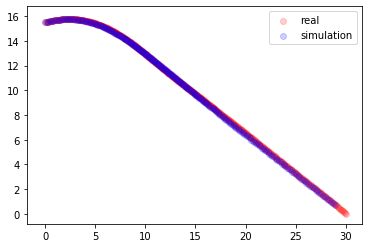

In [5]:
plot_localization(task['task_0'][0])

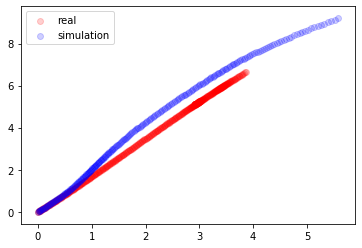

In [6]:
plot_localization(task['task_0'][4])

Теперь нарисуем какие-нибудь простые гистограммы, чтобы посмотреть чем отличаются распределения

In [7]:
def plt_hist(task, f, key_1="real", key_2="simulation"):
    features_real = []
    features_simulation = []

    for scene_id in task:
        scene = task[scene_id]
        features_real.append(f(scene[key_1]))
        features_simulation.append(f(scene[key_2]))
    x_min = min(min(features_real), min(features_simulation))
    x_max = max(max(features_real), max(features_simulation))
    plt.hist(features_real, color="#FF000030", label="real", range=(x_min, x_max))
    plt.hist(features_simulation, color="#0000FF30", label="simulation", range=(x_min, x_max))
    plt.legend()

In [8]:
def length(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

def mean_position_change(scene):
    diffs = []
    for previous, current in zip(scene['localization_messages'], scene['localization_messages'][1:]):
        diffs.append(length(current['position'], previous['position']))
    return np.mean(diffs)

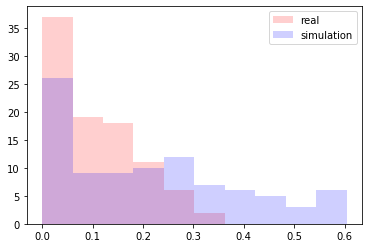

In [9]:
plt_hist(task['task_0'], mean_position_change)

Почему-то среднее перемещение между сообщениями отличается в два раза?

In [10]:
def norm(a):
    return (a[0] ** 2 + a[1] ** 2) ** 0.5

def mean_velocity_norm(scene):
    velocities = []
    for current in scene['localization_messages']:
        velocities.append(norm(current['linear_velocity']))
    return np.mean(velocities)

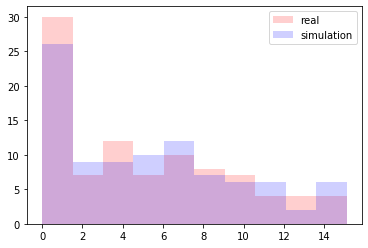

In [11]:
plt_hist(task['task_0'], mean_velocity_norm)

При этом средняя скорость не меняется в течение сцены

In [12]:
def total_sum_of_position_changes(scene):
    diffs = []
    for previous, current in zip(scene['localization_messages'], scene['localization_messages'][1:]):
        diffs.append(length(current['position'], previous['position']))
    return sum(diffs)

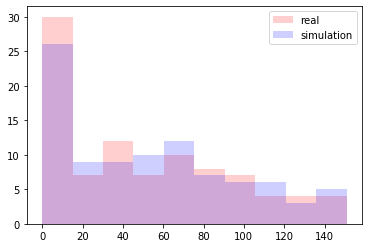

In [13]:
plt_hist(task['task_0'], total_sum_of_position_changes)

Суммарное перемещение тоже не отличается (то есть мы оказываемся в нужной точке), значит отличается количество этих перемещений

In [14]:
def message_count(scene):
    return len(scene['localization_messages'])

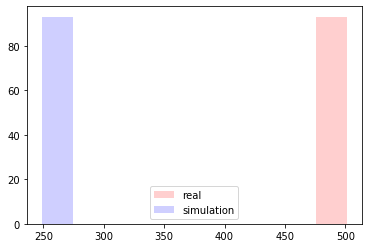

In [15]:
plt_hist(task['task_0'], message_count)

И правда, почему-то симулятор "проглатывает" половину сообщений и отдает только каждое второе

Давайте рассмотрим ситуацию, когда симулятор начинает вести себя неожиданно плохо - например, удалять половину сообщений или агентов со сцены, тогда дискриминатор легко сможет отличать симуляцию от реальности просто по числу агентов.

Пока команда исправляет логику симулятора - нужно продолжать работу и оценивать, что поведение все еще близко к жизни, поэтому вводится новый сетап - `replay`

<img src="replay_simulator.png" alt="image.png" width="700"/>

`replay` - запускает симуляцию с указанием, чтобы все вокруг и сам ровер двигались как было записано, ничего не меняя (как будто прогрев идет все 15 секунд), используется предположение, что артефакты удаления одинаковые на replay прогоне и на обычном, поэтому таким образом мы измеряем дважды:

- первый дискриминатор проверяет, что сквозь симулятор "ничего не теряется" (ну или не добавляется =))
- а второй дискриминатор уже проверяет, что симуляция похожа на жизнь

В данном случае нам понадобится второй дискриминатор

# Часть 1. Анализ локализации

Использовать мы будем просто статистические фичи, теперь нам их нужно придумать

In [16]:
task["task_1"][0]['replay']['localization_messages'][0]

{'stamp': 1627766908130827594,
 'position': [0.00016008896439956288, 0.0003346242847044323],
 'linear_velocity': [0.0, 0.0],
 'acceleration': [0.00021529561707727185, 0.0006544959484798464]}

In [17]:
def scene_to_features(scene):
    diffs = []
    for previous, current in zip(scene['localization_messages'], scene['localization_messages'][1:]):
        diffs.append(length(current['position'], previous['position']))
    return [
        np.max(diffs),
        np.min(diffs),
        np.std(diffs),
        np.mean(diffs),
    ]

В обучающем цикле будем просто бить наш датасет пополам по четности и предсказывать roc-auc на тестовой части

In [18]:
def train(f, task):
    features_real_train = []
    features_real_test = []
    features_simulation_train = []
    features_simulation_test = []

    for scene_id in task:
        scene = task[scene_id]
        if scene_id % 2 == 0:
            features_real_train.append(f(scene['replay']))
            features_simulation_train.append(f(scene['simulator']))
        else:
            features_real_test.append(f(scene['replay']))
            features_simulation_test.append(f(scene['simulator']))
    x_train = features_real_train + features_simulation_train
    x_test = features_real_test + features_simulation_test

    y_train = [1] * len(features_real_train) + [0] * len(features_simulation_train)
    y_test = [1] * len(features_real_test) + [0] * len(features_simulation_test)

    cb = catboost.CatBoostClassifier(verbose=False)
    cb.fit(x_train, y_train)
    return cb, roc_auc_score(y_test, cb.predict(x_test))

In [19]:
cb, score = train(scene_to_features, task['task_1'])

In [20]:
score

0.7923046721633293

Даже на простых фичах он быстро находит какое-то отличие, посмотрим на важные фичи

In [21]:
sorted(zip(cb.get_feature_importance(), ["max", "min", "std", "mean"]), reverse=True)

[(62.176970157242124, 'min'),
 (17.505241176958, 'max'),
 (11.757037601619963, 'std'),
 (8.56075106417992, 'mean')]

Построим гистрограммы

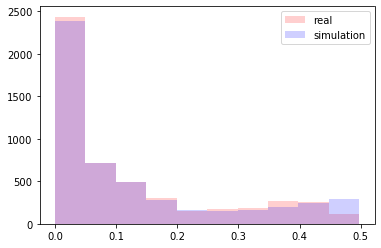

In [22]:
plt_hist(task['task_1'], lambda x: scene_to_features(x)[1], key_1="replay", key_2="simulator")

Несмотря на то, что распределения по отдельности не сильно отличаются - даже простая модель уровня деревьев умеет учитывать несколько фичей за раз - возможно в одной сцене не должно быть слишком большой разницы между минимальным и максимальным перемещением или наоборот

Придумаем больше фичей

In [23]:

def scene_to_features_2(scene):
    diffs = []
    diffs_accs = []
    for previous, current in zip(scene['localization_messages'], scene['localization_messages'][1:]):
        diffs.append(length(current['position'], previous['position']))
        diffs_accs.append(length(current['acceleration'], previous['acceleration']))
    velocities = []
    for current in scene['localization_messages']:
        velocities.append(norm(current['linear_velocity']))
    accelerations = []
    for current in scene['localization_messages']:
        accelerations.append(norm(current['acceleration']))
    return [
        np.max(diffs),
        np.min(diffs),
        np.std(diffs),
        np.mean(diffs),
        np.max(velocities),
        np.min(velocities),
        np.std(velocities),
        np.mean(velocities),
        np.max(accelerations),
        np.min(accelerations),
        np.std(accelerations),
        np.mean(accelerations),
        np.max(diffs_accs),
        np.min(diffs_accs),
        np.std(diffs_accs),
        np.mean(diffs_accs),
    ]

In [24]:
cb_ext, score_ext = train(scene_to_features_2, task['task_1'])

In [25]:
score_ext

0.9998036906164114

В данном случае, чем более сложные статистики мы даем - сначала скорости, потом ускорения, затем их производные, тем более сложная модель физики нам понадобится, чтобы их учесть. И тем легче дискриминатору отличить, что перед ним симуляция - имея текущие данные, успешность его предсказаний будет близка к 100%

# Выводы

В данном примере для симуляции физики была использована велосипедная модель: мы представляем, что автомобиль - это велосипед, у которого две совместные оси и есть точка вокруг, которой идет поворот

<img src="bicycle.png" alt="image.png" width="700"/>

Подробнее, можно прочитать тут https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html

Из-за того, что такая модель требует внешних параметров (которые ищутся с помощью экспериментов), а так же не полностью моделирует поведение четырехколесных устройств - то и дискриминатор не очень сложно может его отличить

# Часть 2 - Сравнение локализаций

Попробуем посмотреть, что будет на другом виде симуляции физики

In [26]:
cb_2, score_2 = train(scene_to_features, task['task_2'])

In [27]:
cb_ext_2, score_ext_2 = train(scene_to_features_2, task['task_2'])

In [28]:
score, score_2

(0.7923046721633293, 0.7890287062524577)

In [29]:
score_ext, score_ext_2

(0.9998036906164114, 1.0)

Как видно, разный набор фичей дает разные результаты: где-то лучше первая физика, где-то вторая. Возможно, второй вид симуляции физики лучше учитывает перемещения, но хуже учитывает более сложные физические зависимости такие как ускорения.

Конечно, разница в 0.0001 не слишком показательна, в данном случае скорее для примера, что от выбора фичей может зависеть результат 

# Домашняя работа

Посмотрите лекцию и семинар, иначе будет сложно осознать, что происходит. Теперь кроме локализации, у вас доступна информация о других участниках движения, нужно понять насколько реалистично мы их симулируем

# Задание 0 - Чтение данных

Данные лежат в трех файлах - `replay.zip`, `simulator_1.zip`, `simulator_2.zip`. Суммарно они весят порядка 10 ГБ, при распаковке на порядки больше, поэтому не на каждое устройство получится загрузить все в оперативку.

Поэтому предлагается - загрузить не все 25000 сцен, а для начала первые 1000, обучиться и поотлаживать фичи на них, а затем переписать на стриминговую версию, где сохраняются не исходные данные, а только фичи от сцены

In [38]:
from tqdm import tqdm

import zipfile
import json

# Просто чтение

scenes = []
with zipfile.ZipFile('replay.zip', 'r') as replay:
    file_names = [i.filename for i in replay.filelist]
    scene_ids = sorted(file_names)[:1000]
    for i in tqdm(scene_ids, total=1000):
        with replay.open(i) as scene_content:
            scene = json.loads(scene_content.read())
            scenes.append(scene)
            
# Стриминговое чтение

f = lambda x: [0] # ваша функция фичей
features = []
with zipfile.ZipFile('replay.zip', 'r') as replay:
    file_names = [i.filename for i in replay.filelist]
    scene_ids = sorted(file_names)
    for i in tqdm(scene_ids):
        with replay.open(i) as scene_content:
            scene = json.loads(scene_content.read())
            features.append(f(scene))

100%|██████████| 23142/23142 [13:45<00:00, 28.03it/s]  


# Задание 1 - Улучшение симулятора

По аналогии с ровером, нарисуйте на одной сцене всех участников движения, используйте разные цвета для пешеходов и автомобилей **(0.5 балла)**


Cделайте отрисовку в виде "гиф" или динамического видео, чтобы понимать как движение было устроено внутри сцены, а не просто пересечение траекторий **(0.5 балла)**

<img src="vizualization.png" alt="image.png" width="700"/>

# Задание 2 - Анализ поведения агентов

- Адаптируйте фичи из семинара под формат описания пешеходов и автомобилей (в дальнейшем - агентов) **(0.5 балла)**
- Придумайте и напишите фичи про взаимодействия агентов между собой(столкновения? обгоны?) **(1 балл)**
- Придумайте и напишите фичи про количество и дальность, появление и исчезание агентов **(1 балл)**
- Придумайте какие-либо еще фичи, за креативность - **бонусные баллы** 
- Обучите модель на `replay.zip` + `simulator_1.zip`, проанализируйте важность фичей, постройте гистограммы и сделайте выводы о том, что сильнее всего выдает симуляцию **(1.5 балла)**


**NOTE**: Будьте внимательны, если на каком-то подмножестве фичей ваша модель уже дает roc-auc 1, попробуйте выделить топ важных фичей, написать их в отчёте и удалить из обучения, чтобы убеждаться, что другие фичи тоже вносят вклад


- В семинаре мы обучали только одну модель, если мы хотим оценить реалистичность конкретной сцены, то можем сделать это только для половины нашего датасета. Чтобы это избежать, можно обучать несколько фолдов и допустим для 5-fold кросс-валидации - у нас будет известно для каждой сцены по числу, причем на основе не 50% датасета, а 80% - реализуйте это **(1 балл)**


- Кроме того, необязательно учить именно классификатор, можно учить ранкер, обучите catboost с pairwise лоссом на ваш выбор - https://catboost.ai/en/docs/concepts/loss-functions-ranking , проанализируйте изменились ли важные фичи, посчитайте метрику pairwise accuracy (для какой доли сцен `realness(perception) > realness(simulated_perception)`), есть ли сцены для которых симуляция реалистичнее реального проезда? Как вы думаете почему? **(1 балл)**

# Задание 3 - Сравнение версий симуляции

Вернемся к одной из исходных целей дискриминатора - научиться принимать релизы симулятора, предположим к вам приходит новая конфигурация симулятора, нужно понять насколько он хуже/лучше предыдущего

- Обучите дискриминатор на `replay.zip` + `simulator_2.zip` и постройте важные фичи **(1 балл)**
- Найдите сцены, в которых больше всего изменился вердикт дискриминатора, допустим был 0.9 а стал 0.1 или наоборот и нарисуйте их рядом с помощью своей визуализации из первой части домашки **(1 балл)**
- Попробуйте объяснить, что изменилось в этом конфиге. Приняли бы вы такой релиз?  **(1 балл)**